# Autoencoder

This deep neural networks is made of two parts:
- An encoder: a network that learns to represent/compress the high-dimensional input data into a lower dimensional latent space
- A decoder: a network that learns to decompress a given representation/vector in the latent space to a high-dimensional representation

Often used to remove noise from images.

It is really easy to create an autoencoder using Keras Model Subclassing API as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder).

See also TP1: https://drive.google.com/drive/folders/1KPsQvVDUcJzsDRw7YU-F2TvPLGdcV0An

Let's build an autoencoder "from scratch" to have a better understanding!

## Hand Made Autoencoder

In [40]:
import os
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.utils import plot_model

# Clear TensorFlow session
tf.keras.backend.clear_session()

import matplotlib.pyplot as plt

In [41]:
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.latent_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

### Encoder

In [42]:
class Encoder():

    def __init__(self, input_dim, encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides, latent_dim, batch_norm, dropout):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.input = Input(shape=self.input_dim, name="encoder_input")

        x = self.input

        for i in range(self.encoder_n_layers):
            conv_layer = Conv2D(filters=self.encoder_conv_filters[i],
                                kernel_size=self.encoder_conv_kernel_sizes[i],
                                strides=self.encoder_conv_strides[i],
                                padding="same",
                                name="encoder_conv_" + str(i))
            x = conv_layer(x)
            x = LeakyReLU(name="encoder_leaky_relu_" + str(i))(x)

            if self.batch_norm:
                x = BatchNormalization()(x)

            if self.dropout:
                x = Dropout(rate = 0.25)(x)

        # self.shape_before_flattening = tf.keras.backend.int_shape(x)[1:] # See decoder
        self.shape_before_flattening = x.shape[1:] # See decoder

        x = Flatten(name="encoder_flatten")(x)

        self.output = Dense(self.latent_dim, name="output")(x)

        self.model = Model(self.input, self.output, name="encoder")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)


### Decoder

In [43]:
class Decoder():

    def __init__(self, latent_dim, shape_before_flattening, decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides, output_dim, batch_norm, dropout):
        self.output_dim = output_dim
        self.shape_before_flattening = shape_before_flattening
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.input = Input(shape=(self.latent_dim,), name="decoder_input")

        x = Dense(np.prod(shape_before_flattening))(self.input) # Connect the input to a dense layer

        x = Reshape(self.shape_before_flattening)(x) # Reshape latent space vector for convolutional transpose layers

        for i in range(self.decoder_n_layers):
            conv_t_layer = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                           kernel_size=self.decoder_conv_t_kernel_sizes[i],
                                           strides=self.decoder_conv_t_strides[i],
                                           padding="same",
                                           name="decoder_conv_t_" + str(i))
            x = conv_t_layer(x)

            if i < self.decoder_n_layers - 1:
                x = LeakyReLU(name="decoder_leaky_relu_" + str(i))(x)
                
                if self.batch_norm:
                    x = BatchNormalization()(x)
                if self.dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                # x = Activation("sigmoid")(x)
                x = Activation(tf.keras.activations.sigmoid, name="decoder_sigmoid_" + str(i))(x)

        self.output = x

        self.model = Model(self.input, self.output, name="decoder")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)
        

### Autoencoder

In [44]:
class Autoencoder():

    def __init__(self, input_dim,
                 encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides,
                 latent_dim,
                 decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides,
                 output_dim,
                 learning_rate, batch_norm, dropout):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.output_dim = output_dim
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.learning_rate = learning_rate

        # Create encoder
        self.encoder = Encoder(self.input_dim,
                               self.encoder_n_layers, self.encoder_conv_filters, self.encoder_conv_kernel_sizes, self.encoder_conv_strides,
                               self.latent_dim, self.batch_norm, self.dropout)
        
        # Create decoder
        self.decoder = Decoder(self.latent_dim, self.encoder.shape_before_flattening,
                               self.decoder_n_layers, self.decoder_conv_t_filters, self.decoder_conv_t_kernel_sizes, self.decoder_conv_t_strides,
                               self.output_dim, self.batch_norm, self.dropout)
        
        # Create model
        self.model_input = self.encoder.input
        self.model_output = self.decoder.model(self.encoder.output)

        self.model = Model(self.model_input, self.model_output, name="autoencoder")

        # Compile model
        self.optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss=MeanSquaredError())

    def summary(self):
        self.model.summary()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.encoder.model, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.decoder.model, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes=True, show_layer_names=True)

    def load_weights(self, filepath="model/weights/params.pkl"):
        self.model.load_weights(filepath)

    def fit(self, x, y, batch_size, epochs, validation_split, shuffle, initial_epoch=0, print_every_n_batches=100, lr_decay=1):

        # Callbacks
        # custom_callback = CustomCallback("model", print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        # checkpoint2 = ModelCheckpoint(os.path.join("model", 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [lr_sched]

        # Training
        self.history = self.model.fit(x,
                                      y,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      callbacks=callbacks_list,
                                      validation_split=validation_split,
                                      shuffle=shuffle,
                                      initial_epoch=initial_epoch)
        return self.history

    def predict(self, x):
        return self.model.predict(x)

    def save(self, folder="model"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'weights/params.pkl'), 'wb') as f:
            pickle.dump([self.input_dim,
                         self.encoder_conv_filters,
                         self.encoder_conv_kernel_sizes,
                         self.encoder_conv_strides,
                         self.decoder_conv_t_filters,
                         self.decoder_conv_t_kernel_sizes,
                         self.decoder_conv_t_strides,
                         self.latent_dim,
                         self.batch_norm,
                         self.dropout], f)
        self.plot_model(folder)

In [45]:
LATENT_DIM = 2

autoencoder = Autoencoder(input_dim=(28,28,1),
                          encoder_n_layers=4,
                          encoder_conv_filters=[32,64,64,64],
                          encoder_conv_kernel_sizes=[3,3,3,3],
                          encoder_conv_strides=[1,2,2,1],
                          latent_dim=LATENT_DIM,
                          decoder_n_layers=4,
                          decoder_conv_t_filters=[64,64,32,1],
                          decoder_conv_t_kernel_sizes=[3,3,3,3],
                          decoder_conv_t_strides=[1,2,2,1],
                          output_dim=(28,28,1),
                          learning_rate=0.0005,
                          batch_norm=False,
                          dropout=False)

In [46]:
# autoencoder.plot_model("model")

In [47]:
autoencoder.encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 encoder_leaky_relu_0 (Leak  (None, 28, 28, 32)        0         
 yReLU)                                                          
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 encoder_leaky_relu_1 (Leak  (None, 14, 14, 64)        0         
 yReLU)                                                          
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928 

In [48]:
autoencoder.decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTr  (None, 7, 7, 64)          36928     
 anspose)                                                        
                                                                 
 decoder_leaky_relu_0 (Leak  (None, 7, 7, 64)          0         
 yReLU)                                                          
                                                                 
 decoder_conv_t_1 (Conv2DTr  (None, 14, 14, 64)        3692

In [49]:
# autoencoder.summary()

In [50]:
# DEBUG
# for layer in autoencoder.model.layers:
#     print(layer.name, layer.output_shape)

### Load Data

In [51]:
# Load MNIST dataset
mnist_dataset = mnist.load_data()
(trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
(X_train, y_train) = trainset
(X_test, y_test) = testset

# Preprocess data (convert to float and scale to between 0 and 1)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

# Preprocess data (convert to uint8)
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')

### Train

In [52]:
BATCH_SIZE = 32
# EPOCHS = 200
EPOCHS = 10

In [53]:
autoencoder.fit(x=X_train,
                y=X_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=0.1,
                shuffle=True)

Epoch 1/10
   3/1688 [..............................] - ETA: 1:01 - loss: 0.2308   

2023-11-22 19:32:07.463435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'gradient_tape/model_2/encoder_leaky_relu_2/LeakyRelu/LeakyReluGrad' exist for missing node 'model_2/encoder_conv_2/BiasAdd'.


1688/1688 [==============================] - 60s 34ms/step - loss: 0.0565 - val_loss: 0.0481 - lr: 5.0000e-04
Epoch 2/10
1688/1688 [==============================] - 59s 35ms/step - loss: 0.0468 - val_loss: 0.0450 - lr: 5.0000e-04
Epoch 3/10
1688/1688 [==============================] - 59s 35ms/step - loss: 0.0446 - val_loss: 0.0430 - lr: 5.0000e-04
Epoch 4/10
1688/1688 [==============================] - 59s 35ms/step - loss: 0.0435 - val_loss: 0.0427 - lr: 5.0000e-04
Epoch 5/10
1688/1688 [==============================] - 60s 35ms/step - loss: 0.0427 - val_loss: 0.0418 - lr: 5.0000e-04
Epoch 6/10
1688/1688 [==============================] - 59s 35ms/step - loss: 0.0422 - val_loss: 0.0416 - lr: 5.0000e-04
Epoch 7/10
1688/1688 [==============================] - 59s 35ms/step - loss: 0.0417 - val_loss: 0.0410 - lr: 5.0000e-04
Epoch 8/10
1688/1688 [==============================] - 60s 35ms/step - loss: 0.0414 - val_loss: 0.0406 - lr: 5.0000e-04
Epoch 9/10
1688/1688 [=====================

### Evaluate Autoencoder

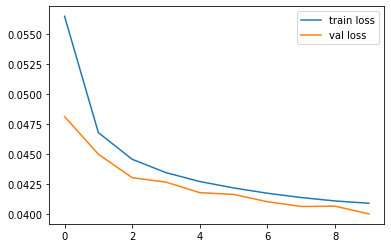

In [54]:
# Plot losses
losses = autoencoder.history.history
plt.plot(losses["loss"], label="train loss")
plt.plot(losses["val_loss"], label="val loss")
plt.legend()
plt.show()

313/313 [==============================] - 4s 13ms/step


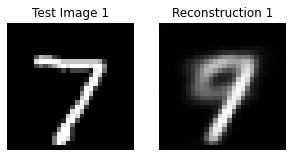

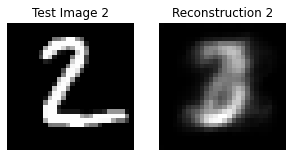

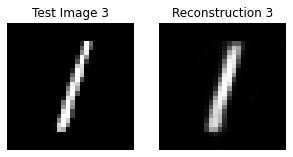

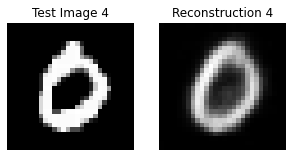

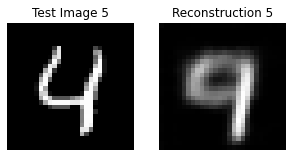

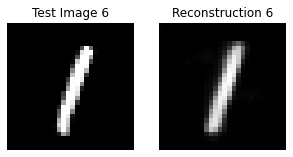

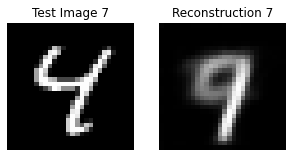

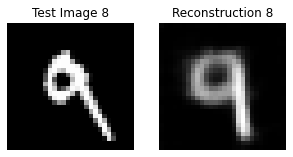

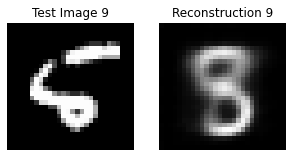

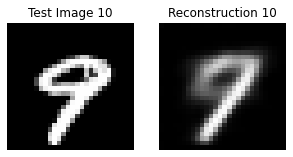

In [55]:
NB_PRED = 10
OFFSET = 0

predictions = autoencoder.predict(X_test)

for i in range(NB_PRED):
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(X_test[OFFSET + i], cmap="gray")
    plt.title("Test Image " + str(i+1))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(predictions[OFFSET + i], cmap="gray")
    plt.title("Reconstruction " + str(i+1))
    plt.axis("off")

### Save Model

In [56]:
autoencoder.save()

### Load Pre-Trained Model

In [57]:
# autoencoder.load_weights()

### Predictions

The distribution of the points in the latent space is unknown. For instance, with the mnist dataset and a latent space in 2D, it is possible top plot where each type of digit is located in the latent space.
- The plot is not symmetrical about the point (0,0): How should one choose a point in the latent space to produce a specific digit?
- Some digits are represented in the latent space over small areas and others over large areas: There will be a lack of diversity in the images produced. (More of the digits with the larger areas).
- There are large gaps between digits that contains few individuals: Some generated images (from the gaps) will be porrly formed
- The latent space is not continuous: Points in the middle of digits areas can also be ill-formed

1/1 [==============================] - 0s 221ms/step


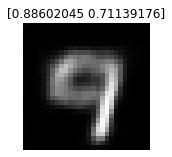

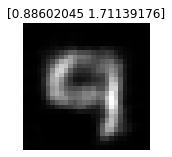

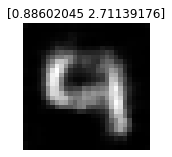

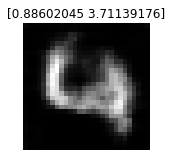

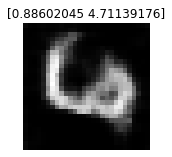

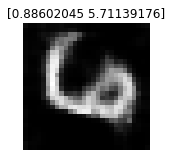

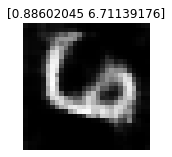

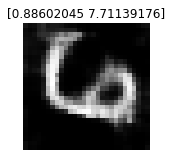

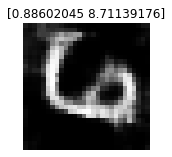

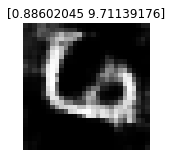

In [62]:
NB_PRED = 10

latent_vector_init = np.random.random(size=(LATENT_DIM))

latent_vectors = np.array([latent_vector_init + np.array([0, i]) for i in range(NB_PRED)])

predictions = autoencoder.decoder.predict(latent_vectors)

for i in range(NB_PRED):
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i], cmap="gray")
    plt.title(f"{latent_vectors[i]}")
    plt.axis("off")

In [58]:
NB_PRED = 10

latent_vector_init = np.random.random(size=(1,2))

latent_vectors = tf.data.Dataset.from_tensor_slices([latent_vector_init + np.array([0, i]) for i in range(NB_PRED)])

list(latent_vectors.as_numpy_iterator())

[array([[0.95800853, 0.93594404]]),
 array([[0.95800853, 1.93594404]]),
 array([[0.95800853, 2.93594404]]),
 array([[0.95800853, 3.93594404]]),
 array([[0.95800853, 4.93594404]]),
 array([[0.95800853, 5.93594404]]),
 array([[0.95800853, 6.93594404]]),
 array([[0.95800853, 7.93594404]]),
 array([[0.95800853, 8.93594404]]),
 array([[0.95800853, 9.93594404]])]

In [59]:
latent_vectors

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 2), dtype=tf.float64, name=None)>

10/10 [==============================] - 0s 4ms/step


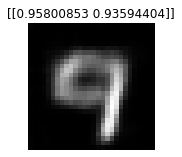

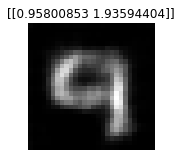

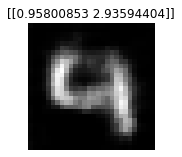

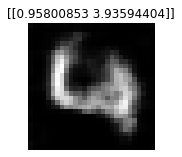

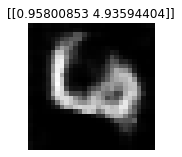

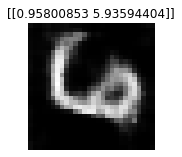

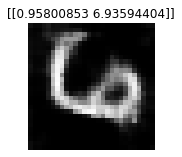

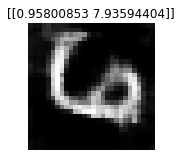

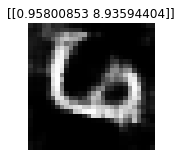

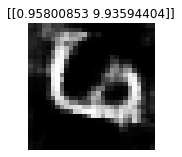

In [60]:
predictions = autoencoder.decoder.predict(latent_vectors)

latent_vectors_iterator = iter(latent_vectors)
for i in range(NB_PRED):
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i], cmap="gray")
    plt.title(f"{latent_vectors_iterator.get_next()}")
    plt.axis("off")